In [278]:
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch
from IPython.display import display
from icecream import ic
from math import pi
import matplotlib.pyplot as plt

In [323]:
class single_shape:
	def __init__(self,shape,shape_type,full_shape,inertia_type,axis_type):
		self.shape = shape
		self.shape_type = shape_type
		self.inertia_type = inertia_type
		self.full_shape = full_shape
		self.axis_type = axis_type
		self.get_bounds()
		self.get_inertia()


	
	def get_bounds(self):
		s = self.shape
		self.x_len = (s.bounds[2] - s.bounds[0])
		self.y_len = (s.bounds[3] - s.bounds[1])


		if self.inertia_type == 'I_y':
			self.b = self.y_len
			self.h = self.x_len
			if self.axis_type == 'axis':
				self.p_axis =  (self.shape.area * (self.shape.centroid.x)**2)
			elif self.axis_type == 'centroid':
				self.p_axis =  (self.shape.area * (self.shape.centroid.x - self.full_shape.centroid.x)**2)
			# 


		elif self.inertia_type == 'I_x':
			self.b = self.x_len
			self.h = self.y_len
			if self.axis_type == 'axis':
				self.p_axis =  (self.shape.area * (self.shape.centroid.y)**2)
			elif self.axis_type == 'centroid':
				self.p_axis =  (self.shape.area * (self.shape.centroid.y - self.full_shape.centroid.y)**2)

			# 
		

		# printer
		# ic(self.b)
		# ic(self.h)
		# ic(self.shape.area)
		# ic(self.shape.centroid.x)
		# ic(self.full_shape.centroid.x)
		# ic(self.shape.centroid.y)
		# ic(self.full_shape.centroid.y)
		# print("\n")


	
	def get_inertia(self):
		if self.shape_type == 'Rectangle':
			self.inertia = (1/12 * self.b * self.h**3) + self.p_axis
		elif self.shape_type == 'Triangle':
			self.inertia = (1/36 * self.b * self.h**3) + self.p_axis
		elif self.shape_type == 'Circle':
			self.inertia = (1/4 * pi * (self.b/2)**4) + self.p_axis


class full_shape:
	def __init__(self,shapes,inertia_type,axis_type):
		for i,shape in enumerate(shapes):
			if i == 0:
				self.shape = shape['shape']
			elif shape['sign'] == '+':
				self.shape = self.shape.union(shape['shape'])
			else:
				self.shape = self.shape.difference(shape['shape'])

		for i,shape in enumerate(shapes):
			single_inertia = single_shape(shape['shape'],shape['shape_type'],self.shape,inertia_type,axis_type).inertia
			print(f"{i}  {single_inertia:,.2f}")
			if i == 0:
				self.inertia = single_inertia
			elif shape['sign'] == '+':
				self.inertia += single_inertia
			else:
				self.inertia -= single_inertia

		# Plot
		fig,ax = plt.subplots(figsize=(3,3))
		x1,y1,x2,y2 = self.shape.bounds
		xy1 = min(x1,y1)
		xy2 = max(x2,y2)
		ax.set_xlim(xy1,xy2)
		ax.set_ylim(xy1,xy2)
		

		for i,shape in enumerate(shapes):
			S = shape['shape']
			if shape['sign'] == '+':
				ax.add_artist(PolygonPatch(S,facecolor='green',alpha=0.5))
				ax.text(S.centroid.x,S.centroid.y,f"{i+1}",fontsize=10,bbox=dict(facecolor='green', alpha=0.5))
			else:
				ax.add_artist(PolygonPatch(S,facecolor='red',alpha=0.5))
				ax.text(S.centroid.x,S.centroid.y,f"{i+1}",fontsize=10,bbox=dict(facecolor='red', alpha=0.5))

			
		display(ax)

		# display(self.shape)
		
		print(f"I = {self.inertia:,.2f}\n")		
	
				
	def get_shape(self):
		# display(self.shape)
		return self.shape
	
	def draw_shape(self):
		fig,ax = plt.subplots()
		ax.add_artist(PolygonPatch(self.shape))
		
		

		


# Example 1

0  618.74
1  38.48
2  110.83


<AxesSubplot:>

I = 469.43



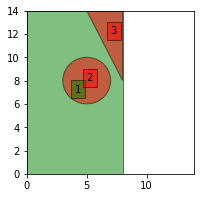

In [324]:
points = [[0,0],
[8,0],
[8,8],
[5,14],
[0,14],]
hole = Point(5,8).buffer(2)
full = Polygon(points)
S1 = full.envelope
S2 = hole
S3 = S1.difference(full)

full = [
	{
		'shape':S1,
		'shape_type':'Rectangle',
		'sign':'+',
		},
	{
		'shape':S2,
		'shape_type':'Circle',
		'sign':'-',
		},
	{
		'shape':S3,
		'shape_type':'Triangle',
		'sign':'-',
		},
]
full_shape(full,"I_y",'centroid')




# Example 2

0  1,433,333,333.33
1  33,333,333.33
2  1,433,333,333.33


<AxesSubplot:>

I = 2,900,000,000.00



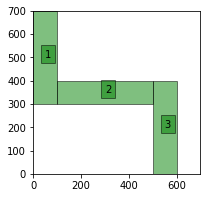

In [325]:
S1 = Polygon([
	[0,700],
	[100,700],
	[100,300],
	[0,300],
	])
S2 = Polygon([
	[100,400],
	[500,400],
	[500,300],
	[100,300],
	])
S3 = Polygon([
	[500,400],
	[600,400],
	[600,0],
	[500,0],
	])

full = [
	{
		'shape':S1,
		'shape_type':'Rectangle',
		'sign':'+',
		},
	{
		'shape':S2,
		'shape_type':'Rectangle',
		'sign':'+',
		},
	{
		'shape':S3,
		'shape_type':'Rectangle',
		'sign':'+',
		},
]
# full_shape(full,"I_x",'centroid').get_shape()
F = full_shape(full,"I_x",'centroid').get_shape()


# full_shape(full,"I_y",'centroid')




0  2.67
1  366.00
2  1,458.67


<AxesSubplot:>

I = 1,827.33



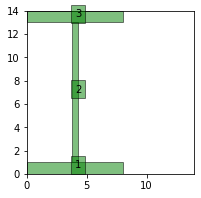

In [326]:
S1 = Polygon([
	[0,0],
	[8,0],
	[8,1],
	[0,1],
	])
S2 = Polygon([
	[3.75,1],
	[4.25,1],
	[4.25,13],
	[3.75,13],
	])
S3 = Polygon([
	[0,13],
	[8,13],
	[8,14],
	[0,14],
	])

# display(S1)
# display(S2)
# display(S3)


shapes = [
	{
		'shape':S1,
		'shape_type':'Rectangle',
		'sign':'+',
		},
	{
		'shape':S2,
		'shape_type':'Rectangle',
		'sign':'+',
		},
	{
		'shape':S3,
		'shape_type':'Rectangle',
		'sign':'+',
		},
]
full_shape(shapes,"I_x",'axis')


# Example 4

0  1,458.00
1  125.48
2  580.50
3  1,093.50


<AxesSubplot:>

I = 1,845.52

0  648.00
1  125.48
2  54.00
3  1,782.00


<AxesSubplot:>

I = 2,250.52



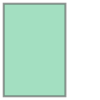

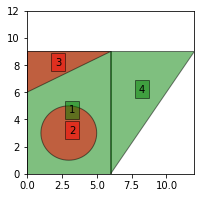

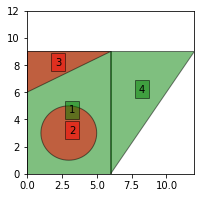

In [327]:
S1 = Polygon([
	[0,0],
	[6,0],
	[6,9],
	[0,9],
	])
S2 = Point(3,3).buffer(2)
S3 = Polygon([
	[0,6],
	[0,9],
	[6,9],
	])
S4 = Polygon([
	[6,0],
	[12,9],
	[6,9],
	])



shapes = [
	{
		'shape':S1,
		'shape_type':'Rectangle',
		'sign':'+',
		},
	{
		'shape':S2,
		'shape_type':'Circle',
		'sign':'-',
		},
	{
		'shape':S3,
		'shape_type':'Triangle',
		'sign':'-',
		},
	{
		'shape':S4,
		'shape_type':'Triangle',
		'sign':'+',
		},
]
full_shape(shapes,"I_x",'axis')
F = full_shape(shapes,"I_y",'axis').get_shape()

# F.intersection(S1)
F.envelope.intersection(S1)
